<a href="https://colab.research.google.com/github/lucienrivat/PommePOire/blob/main/PommePoir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import cv2
import numpy as np
import tensorflow as tf
import pathlib
import os
import zipfile
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import files

# Fonction pour convertir toutes les images en niveaux de gris
def convert_to_grayscale(input_folder):
    for img_path in pathlib.Path(input_folder).rglob("*.*"):
        img = cv2.imread(str(img_path))
        if img is not None:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(str(img_path), gray_img)

# Télécharger et extraire les fichiers ZIP Apple et Pear
apple_zip = tf.keras.utils.get_file("Apple.zip", "https://github.com/lucienrivat/PommePOire/raw/main/apple.zip", extract=False)
pear_zip = tf.keras.utils.get_file("Pear.zip", "https://github.com/lucienrivat/PommePOire/raw/main/pear.zip", extract=False)

with zipfile.ZipFile(apple_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets/')
with zipfile.ZipFile(pear_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets/')

# Définir les chemins
apple_data_dir = pathlib.Path('/content/datasets/apple')
pear_data_dir = pathlib.Path('/content/datasets/pear')

# Convertir toutes les images en niveaux de gris
convert_to_grayscale(apple_data_dir)
convert_to_grayscale(pear_data_dir)

# Paramètres
data_dir = pathlib.Path('/content/datasets/')
batch_size = 3
img_height = 200
img_width = 200

# Charger le dataset avec un traitement en niveaux de gris
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="training", seed=42,
    image_size=(img_height, img_width), batch_size=batch_size, color_mode='grayscale'
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="validation", seed=42,
    image_size=(img_height, img_width), batch_size=batch_size, color_mode='grayscale'
)

import collections

train_labels = []
for images, labels in train_data:
    train_labels.extend(labels.numpy())

counter = collections.Counter(train_labels)
print("Répartition des classes dans l'entraînement :", counter)

Found 6427 files belonging to 2 classes.
Using 5142 files for training.
Found 6427 files belonging to 2 classes.
Using 1285 files for validation.
Répartition des classes dans l'entraînement : Counter({1: 4184, 0: 958})


Epoch 1/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.8760 - loss: 0.6244 - val_accuracy: 0.9844 - val_loss: 0.0741
Epoch 2/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9757 - loss: 0.2360 - val_accuracy: 0.9922 - val_loss: 0.0436
Epoch 3/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9870 - loss: 0.1107 - val_accuracy: 0.9914 - val_loss: 0.0446
Epoch 4/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9909 - loss: 0.0858 - val_accuracy: 0.9953 - val_loss: 0.0383
Epoch 5/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9847 - loss: 0.2940 - val_accuracy: 0.9946 - val_loss: 0.0509
Epoch 6/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9944 - loss: 0.0565 - val_accuracy: 0.9961 - val_loss: 0.0381
Epoch 7/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9984 - loss: 0.0113 - val_accuracy: 0.9953 - val_loss: 0.0755
Epoch 8/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9952 - loss: 0

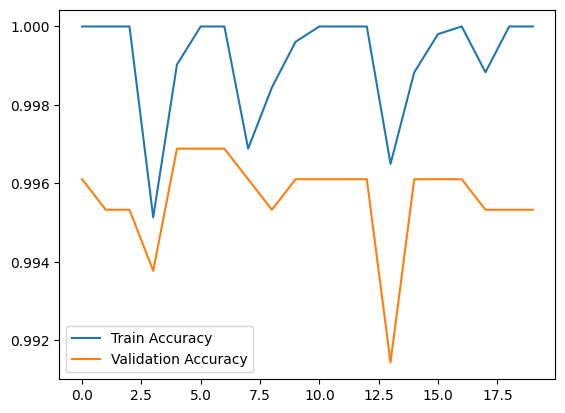

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 200, 200, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 198, 198, 128)       │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 99, 99, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 97, 97, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 46, 46, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 21, 21, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 10, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,621,352 (6.18 MB)

 Trainable params: 540,450 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,080,902 (4.12 MB)

In [14]:
# Définition du modèle CNN adapté aux images en niveaux de gris
num_classes = 2
model = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Entraînement
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="logs", histogram_freq=1, write_images=True)

class_weights = {0: len(train_labels) / 958, 1: len(train_labels) / 4184}

history = model.fit(train_data, validation_data=val_data, epochs=15, callbacks=[tensorboard_callback])

# Tracer l'évolution de l'entraînement
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
model.summary()


Saving R.png to R (3).png


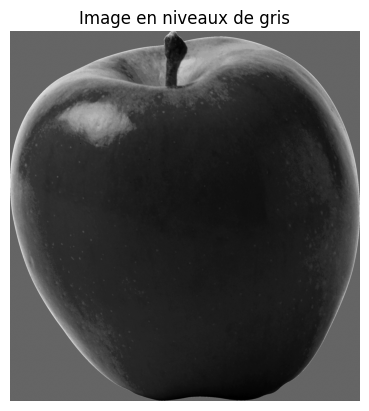

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
Probabilités prédites : [[6.2887265e-11 1.0000000e+00]]
Classe prédite : 1 (0 = Pomme, 1 = Poire)
🍐 C'est une poire !


In [15]:
# Fonction de prédiction avec conversion en niveaux de gris
def predict_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Erreur : Impossible de charger l'image.")
        return None

    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title("Image en niveaux de gris")
    plt.show()

    img_to_predict = cv2.resize(image, (200, 200))
    img_to_predict = img_to_predict / 255.0
    img_to_predict = np.expand_dims(img_to_predict, axis=0)
    img_to_predict = np.expand_dims(img_to_predict, axis=-1)

    predictions = model.predict(img_to_predict)
    print("Probabilités prédites :", predictions)

    predicted_class = np.argmax(predictions)
    print(f"Classe prédite : {predicted_class} (0 = Pomme, 1 = Poire)")
    return predicted_class


# Téléchargement et prédiction
def process_uploaded_files():
    file_to_predict = files.upload()
    for file_ in file_to_predict:
        predicted_class = predict_image(file_)
        if predicted_class == 0:
            print("🍏 C'est une pomme !")
        elif predicted_class == 1:
            print("🍐 C'est une poire !")
        else:
            print("Classe inconnue.")

process_uploaded_files()
